In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "std_phon_trace", "phonetic_trace","traces_fourier", "syllables_fourier"]
INTERESTING_TRACES += [f"syllables_{i}_ts" for i in range(7)]

## Save folder for long-run estimators
ESTIMATORS_FOLDER = os.path.join("..", "estimators")

## Import

In [2]:
df = pd.read_csv(DF_PREPROC_FILE)

traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
print(traces["syll_labels"].shape)

(17164,)


## Metrics

In [3]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

In [4]:
mat_euclidean = cdist(traces["traces_fourier"],traces["traces_fourier"])

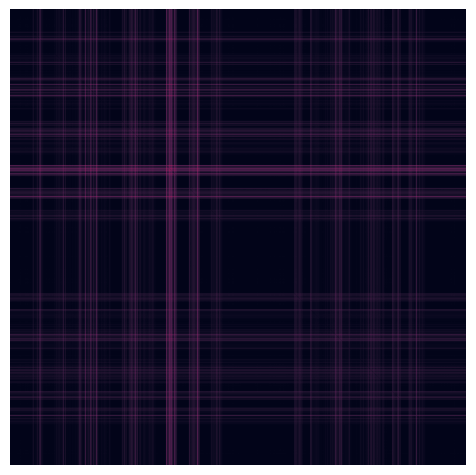

In [5]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_euclidean)

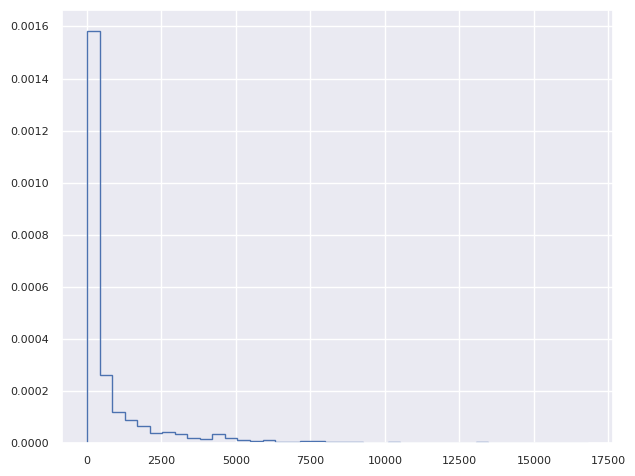

In [6]:
# Distribution of distances
distances_eucl = np.triu(mat_euclidean).reshape(-1)
distances_eucl = distances_eucl[distances_eucl != 0.0]
plt.hist(distances_eucl, histtype="step", bins=40, density=True);

### Manhattan

In [7]:
mat_manhattan = cdist(traces["traces_fourier"],traces["traces_fourier"], metric="cityblock")

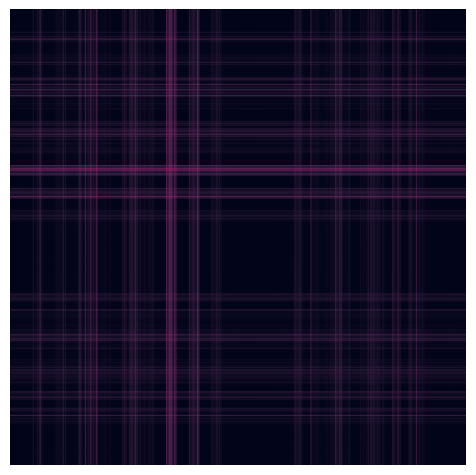

In [8]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_manhattan)

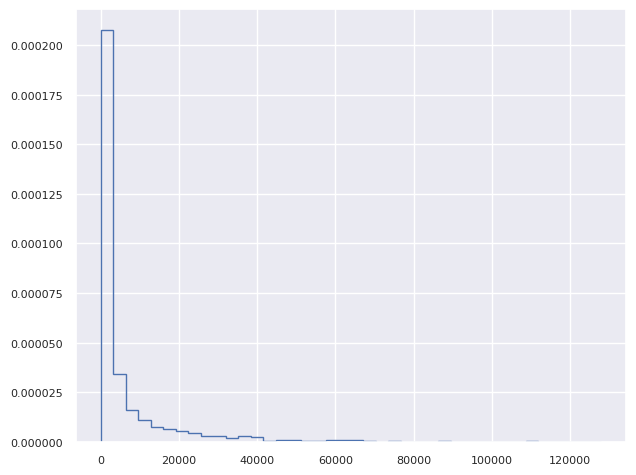

In [9]:
# Distribution of distances
distances_man = np.triu(mat_manhattan).reshape(-1)
distances_man = distances_man[distances_man != 0.0]
plt.hist(distances_man, histtype="step", bins=40, density=True);

### DTW

In [ ]:
from tslearn.metrics import cdist_dtw

mat_dtw = cdist_dtw(traces["std_phon_trace"][:10],traces["std_phon_trace"][:10], itakura_max_slope=2, n_jobs=-1)

In [ ]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_dtw)

## Test: KNN search

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


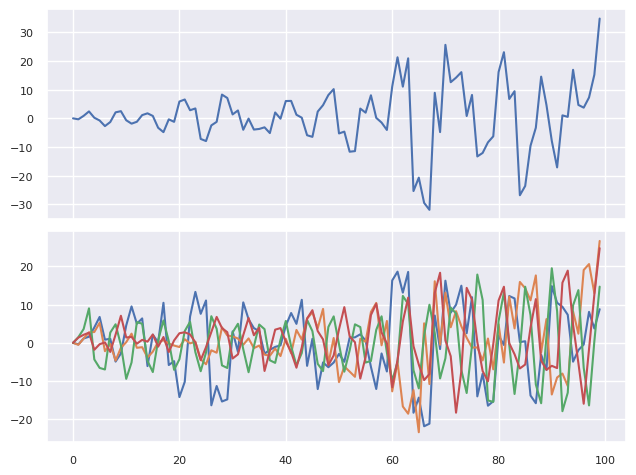

In [10]:
from tslearn.neighbors import KNeighborsTimeSeries
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(traces["traces_fourier"], test_size=0.1)

knn = KNeighborsTimeSeries(n_neighbors=4)
knn.fit(X_train)

# Find nearest neighbours of a query trace
query_trace = 1
nearest = knn.kneighbors([X_test[query_trace]], return_distance=False)[0]

fig, (axquery, axnearest) = plt.subplots(2,1, sharex=True)

# Plot the requested query
axquery.plot(X_test[query_trace])

# Plot the most similar results
for idx in nearest:
    axnearest.plot(X_train[idx])

In [ ]:
X_train.shape

## Kmeans

### Euclidean


in test 0.26162847588017274
in train 0.17152364891371258
211
280


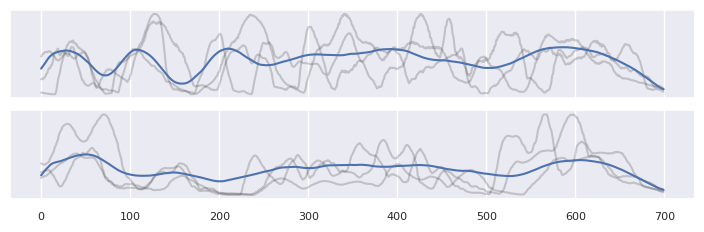

In [9]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_mutual_info_score as ami

X = np.stack(traces["std_phon_trace"])
y = df.vocal_channel

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

##############################

n_clusters = 2

km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False)
y_pred = km.fit_predict(X_test)
print()
print("in test",ami(y_test, y_pred))
print("in train",ami(y_train, km.fit_predict(X_train)))

fig, axes = plt.subplots(n_clusters,1,sharex=True, figsize=default_style.SHORT_FULLSIZE_FIGURE)

for clus in range(n_clusters):
    cluster_elements = X_test[y_pred == clus]
    print(len(cluster_elements))
    for i in range(3):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    axes[clus].set_yticks([])
    axes[clus].plot(km.cluster_centers_[clus])
plt.savefig("../images/ts_classification.pdf")

### DTW

In [ ]:
n_clusters = 2

# Fit and save
km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="dtw",
                      n_jobs=-1,
                      verbose=True)

y_pred = km.fit_predict(X_train)
# Save the estimator
km.to_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))

km = TimeSeriesKMeans.from_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))
y_pred = km.predict(X_train)

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    for i in range(10):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    axes[clus].plot(km.cluster_centers_[clus])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1961 out of 1961 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.3s
[Parallel(n_jobs=

8.416 --> 

## Clustering on SFA for full audio

In [3]:
from sklearn.model_selection import train_test_split

X = traces["syllables_fourier"]
y = traces["syll_labels"]

M = 10000
subsamp = np.random.randint(len(X), size=M)

X = X[subsamp]
y = y[subsamp]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

57898.669 --> 57099.606 --> 56977.570 --> 56858.661 --> 56858.661 --> 

(array([0, 1]), array([7993,    7]))



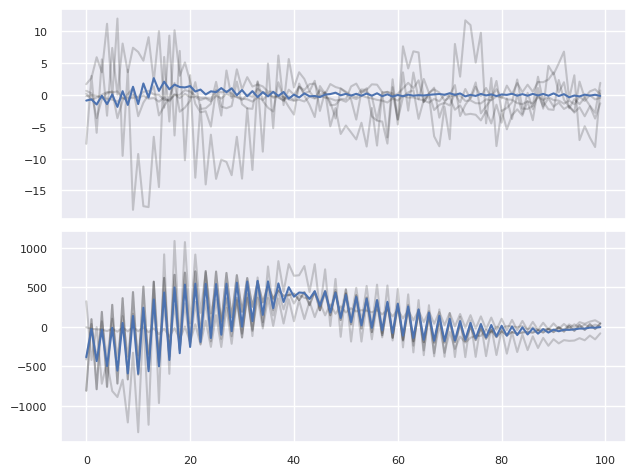

In [4]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 2

km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True)
y_pred = km.fit_predict(X_train)
print()
print(np.unique(y_pred, return_counts=True))
print()
fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    for i in range(5):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(km.cluster_centers_[clus])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_j

41817.173 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

32774.136 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31961.280 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31729.405 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31539.966 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31523.366 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.516 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

31521.510 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

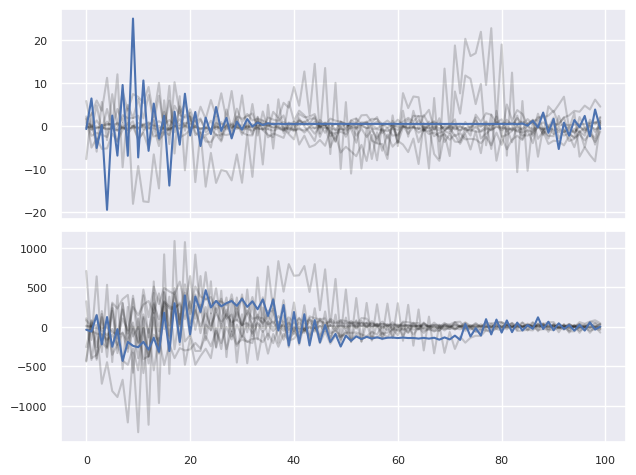

In [5]:
n_clusters = 2

# Fit and save
km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="dtw",
                      n_jobs=-1,
                      verbose=False)

y_pred = km.fit_predict(X_train)
# Save the estimator
km.to_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))

km = TimeSeriesKMeans.from_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))
y_pred = km.predict(X_train)

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    for i in range(10):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    axes[clus].plot(km.cluster_centers_[clus])

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score as ami

